In [41]:
!pip install chaospy

In [42]:
import chaospy
import numpy

alpha = chaospy.Normal(1.5, 0.2)
beta = chaospy.Uniform(0.1, 0.2)
joint = chaospy.J(alpha, beta)

Galerkin projection

In [43]:
gauss_quads = [
    chaospy.generate_quadrature(order, joint, rule="gaussian") # Gaussian here means not a specfic quadrature for a given distribution, but supported to all kind of distributions
    for order in range(1, 8)
]

In [44]:
len(gauss_quads)

7

In [45]:
gauss_quads[0] # node and weights


(array([[1.3       , 1.3       , 1.7       , 1.7       ],
        [0.12113249, 0.17886751, 0.12113249, 0.17886751]]),
 array([0.25, 0.25, 0.25, 0.25]))

In [46]:
sparse_quads = [
    chaospy.generate_quadrature(
        order, joint, rule=["genz_keister_24", "clenshaw_curtis"], sparse=True)
    for order in range(1, 5)
]

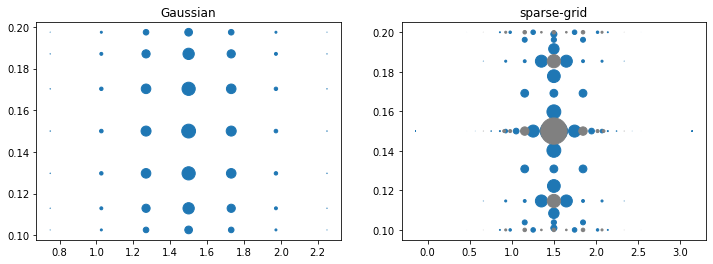

In [47]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[12, 4])

nodes, weights = gauss_quads[5]

pyplot.subplot(121)
pyplot.title("Gaussian")
pyplot.scatter(*nodes, s=weights*2e3)

nodes, weights = sparse_quads[3]
idx = weights > 0

pyplot.subplot(122)
pyplot.title("sparse-grid")
pyplot.scatter(*nodes[:, idx], s=weights[idx]*2e3)
pyplot.scatter(*nodes[:, ~idx], s=-weights[~idx]*2e3, color="grey")

pyplot.show()

In [48]:
coordinates = numpy.linspace(0, 10, 1000)


def model_solver(parameters):
    """
    Simple ordinary differential equation solver.

    Args:
        parameters (numpy.ndarray):
            Hyper-parameters defining the model initial
            conditions alpha and growth rate beta.
            Assumed to have ``len(parameters) == 2``.

    Returns:
        (numpy.ndarray):
            Solution to the equation.
            Same shape as ``coordinates``.
    """
    alpha, beta = parameters
    return alpha*numpy.e**-(coordinates*beta)

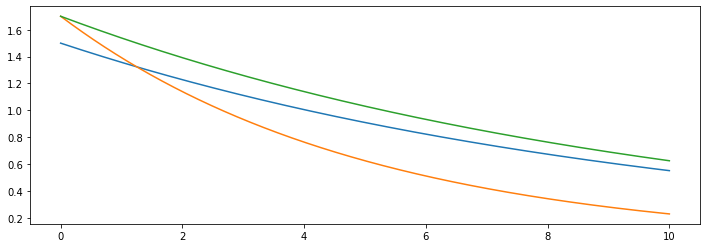

In [49]:
from matplotlib import pyplot

pyplot.plot(coordinates, model_solver([1.5, 0.1]))
pyplot.plot(coordinates, model_solver([1.7, 0.2]))
pyplot.plot(coordinates, model_solver([1.7, 0.1]))

pyplot.show()

Text(0.5, 1.0, 'Gaussian')

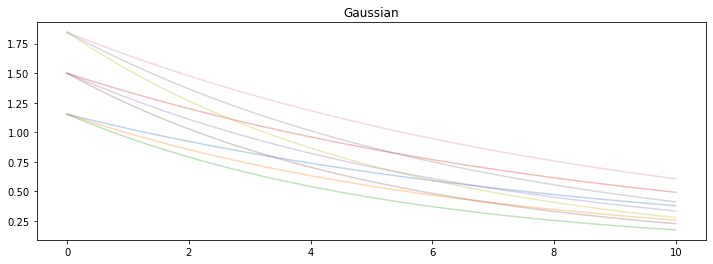

In [50]:
gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in gauss_quads[0:2]
]
pyplot.subplot(111)
pyplot.plot(coordinates, gauss_evals[1].T, alpha=0.3)
pyplot.title("Gaussian")

In [51]:
gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in gauss_quads
]

In [52]:
sparse_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in sparse_quads
]

In [67]:
gauss_evals[0].shape

(4, 1000)

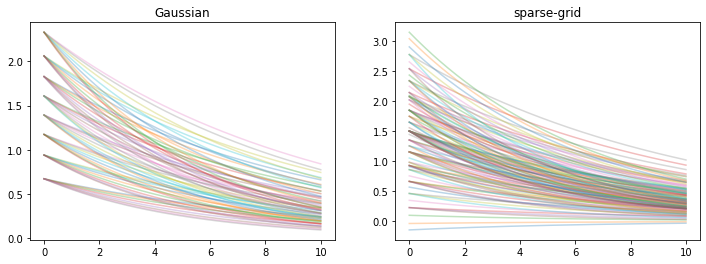

In [53]:
pyplot.subplot(121)
pyplot.plot(coordinates, gauss_evals[6].T, alpha=0.3)
pyplot.title("Gaussian")

pyplot.subplot(122)
pyplot.plot(coordinates, sparse_evals[3].T, alpha=0.3)
pyplot.title("sparse-grid")

pyplot.show()

In [80]:
gauss_quads[3][0].shape

(2, 25)

In [81]:
expansions = [chaospy.generate_expansion(order, joint)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q1-0.15, q0-1.5])

In [82]:
gauss_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, gauss_quads, gauss_evals)
]

In [83]:
len(gauss_model_approx)

7

In [84]:
gauss_model_approx[0].shape

(1000,)

In [85]:
sparse_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, sparse_quads, sparse_evals)
]

Text(0.5, 1.0, 'Gaussian')

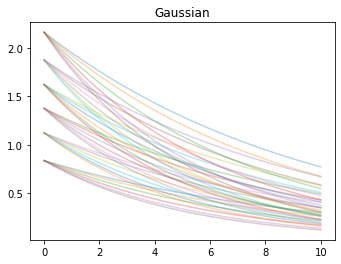

In [86]:
model_approx = gauss_model_approx[4]
nodes, _ = gauss_quads[4]
evals = model_approx(*nodes)

pyplot.subplot(121)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian")

In [87]:
model_approx.shape

(1000,)

In [91]:
model_approx[0]

polynomial(3.0605153268870002e-12*q1**2-2.927345865710863e-14*q0*q1-5.005964718272897e-14*q0**2-8.836119168507119e-13*q1+1.0000000000001579*q0-5.4459896734595935e-14)

In [88]:
gauss_quads[4][0].shape

(2, 36)

In [89]:
evals.shape

(1000, 36)

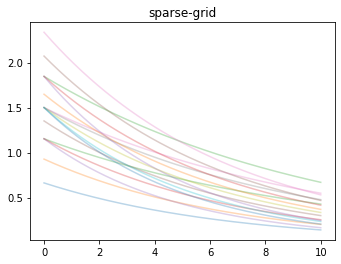

In [90]:


model_approx = sparse_model_approx[1]
nodes, _ = sparse_quads[1]
evals = model_approx(*nodes)

pyplot.subplot(122)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("sparse-grid")

pyplot.show()

In [92]:
expected = chaospy.E(gauss_model_approx[-2], joint)
std = chaospy.Std(gauss_model_approx[-2], joint)

expected[:4].round(4), std[:4].round(4)

(array([1.5   , 1.4977, 1.4955, 1.4933]),
 array([0.2   , 0.1997, 0.1994, 0.1991]))

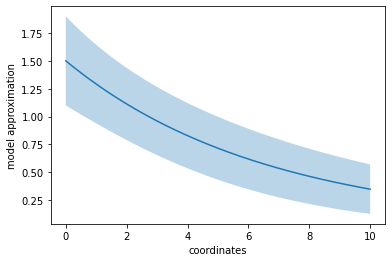

In [93]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.fill_between(
    coordinates, expected-2*std, expected+2*std, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.show()

In [96]:
_t = coordinates[1:]
true_mean = numpy.hstack([
    1.5, 15*(numpy.e**(-0.1*_t)-numpy.e**(-0.2*_t))/_t])
true_variance = numpy.hstack([
    2.29, 11.45*(numpy.e**(-0.2*_t)-numpy.e**(-0.4*_t))/_t])-true_mean**2

In [97]:
def error_in_mean(predicted_mean, true_mean=true_mean):
    """
    How close the estimated mean is the to the true mean.

    Args:
        predicted_mean (numpy.ndarray):
            The estimated mean.
        true_mean (numpy.ndarray):
            The reference mean value. Must be same shape as
            ``prediction_mean``.

    Returns:
        (float):
            The mean absolute distance between predicted
            and true values.
    """
    return numpy.mean(numpy.abs(predicted_mean-true_mean))

In [98]:
def error_in_variance(predicted_variance,
                      true_variance=true_variance):
    """
    How close the estimated variance is the to the true variance.

    Args:
        predicted_variance (numpy.ndarray):
            The estimated variance.
        true_variance (numpy.ndarray):
            The reference variance value.
            Must be same shape as ``predicted_variance``.

    Returns:
        (float):
            The mean absolute distance between
            predicted and true values.
    """
    return numpy.mean(numpy.abs(predicted_variance-true_variance))

In [99]:
gauss_sizes = [len(weights) for _, weights in gauss_quads]
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in gauss_model_approx
]
eps_gauss_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in gauss_model_approx
]

In [100]:
sparse_sizes = [len(weights) for _, weights in sparse_quads]
eps_sparse_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in sparse_model_approx
]
eps_sparse_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in sparse_model_approx
]

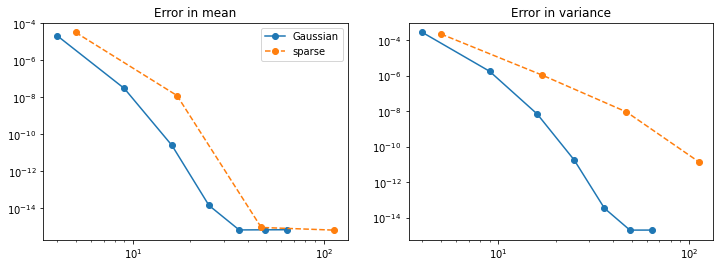

In [101]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(gauss_sizes, eps_gauss_mean, "o-", label="Gaussian")
pyplot.loglog(sparse_sizes, eps_sparse_mean, "o--", label="sparse")
pyplot.legend()

pyplot.subplot(122)
pyplot.title("Error in variance")
pyplot.loglog(gauss_sizes, eps_gauss_var, "o-", label="Gaussian")
pyplot.loglog(sparse_sizes, eps_sparse_var, "o--", label="sparse")

pyplot.show()

Point collection

In [105]:
gauss_quads = [
    chaospy.generate_quadrature(order, joint, rule="gaussian")
    for order in range(1, 8)
]
gauss_nodes = [nodes for nodes, _ in gauss_quads]

In [106]:
sobol_samples = joint.sample(10000, rule="sobol")
sobol_nodes = [sobol_samples[:, :nodes.shape[1]] for nodes in gauss_nodes]

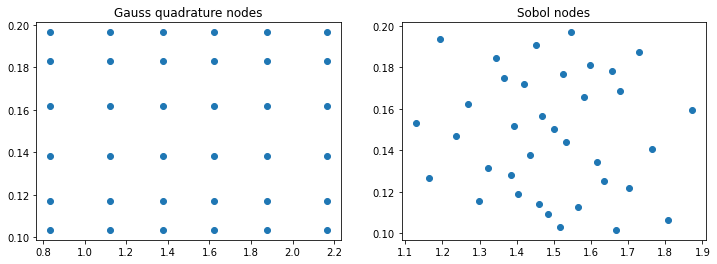

In [107]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.scatter(*gauss_nodes[4])
pyplot.title("Gauss quadrature nodes")

pyplot.subplot(122)
pyplot.scatter(*sobol_nodes[4])
pyplot.title("Sobol nodes")

pyplot.show()

In [109]:
import numpy

gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes in gauss_nodes
]

In [110]:
sobol_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes in sobol_nodes
]

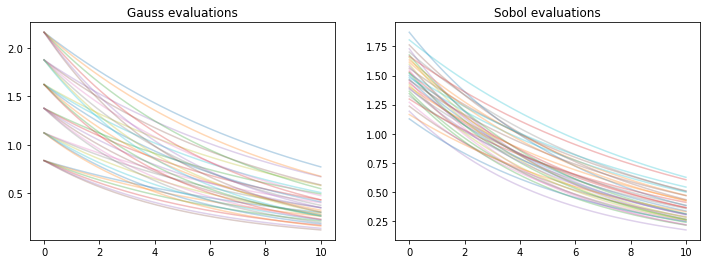

In [112]:
pyplot.subplot(121)
pyplot.plot(coordinates, gauss_evals[4].T, alpha=0.3)
pyplot.title("Gauss evaluations")

pyplot.subplot(122)
pyplot.plot(coordinates, sobol_evals[4].T, alpha=0.3)
pyplot.title("Sobol evaluations")

pyplot.show()

In [113]:
expansions = [chaospy.generate_expansion(order, joint)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q1-0.15, q0-1.5])

In [114]:
gauss_model_approx = [
    chaospy.fit_regression(expansion, samples, evals)
    for expansion, samples, evals in zip(expansions, gauss_nodes, gauss_evals)
]

In [115]:
sobol_model_approx = [
    chaospy.fit_regression(expansion, samples, evals)
    for expansion, samples, evals in zip(expansions, sobol_nodes, sobol_evals)
]

In [126]:
len(sobol_nodes)

7

In [130]:
sobol_nodes[6].shape

(2, 64)

In [132]:
sobol_nodes[1].shape

(2, 9)

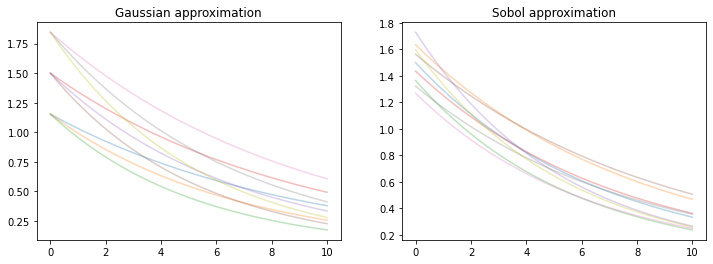

In [116]:
pyplot.subplot(121)
model_approx = gauss_model_approx[4]
evals = model_approx(*gauss_nodes[1])
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian approximation")

pyplot.subplot(122)
model_approx = sobol_model_approx[1]
evals = model_approx(*sobol_nodes[1])
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Sobol approximation")

pyplot.show()

In [131]:
model_approx.shape

(1000,)

In [117]:
expected = chaospy.E(gauss_model_approx[-2], joint)
std = chaospy.Std(gauss_model_approx[-2], joint)

expected[:4].round(4), std[:4].round(4)

(array([1.5   , 1.4977, 1.4955, 1.4933]),
 array([0.2   , 0.1997, 0.1994, 0.1991]))

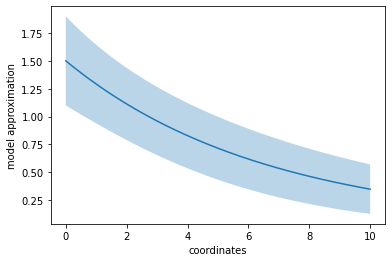

In [118]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.fill_between(
    coordinates, expected-2*std, expected+2*std, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.show()

In [120]:
# from problem_formulation import error_in_mean, error_in_variance

error_in_mean(expected), error_in_variance(std**2)

(1.934119531199485e-15, 3.4890321517350163e-12)

In [121]:
sizes = [nodes.shape[1] for nodes in gauss_nodes]

In [122]:
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in gauss_model_approx
]
eps_gauss_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in gauss_model_approx
]

In [123]:
eps_sobol_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in sobol_model_approx
]
eps_sobol_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in sobol_model_approx
]

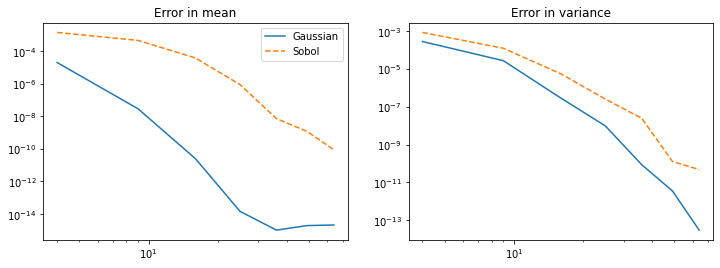

In [124]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(sizes, eps_gauss_mean, "-", label="Gaussian")
pyplot.loglog(sizes, eps_sobol_mean, "--", label="Sobol")
pyplot.legend()

pyplot.subplot(122)
pyplot.title("Error in variance")
pyplot.loglog(sizes, eps_gauss_var, "-", label="Gaussian")
pyplot.loglog(sizes, eps_sobol_var, "--", label="Sobol")

pyplot.show()

Test: Ali Mesbah's work

In [134]:
theta = chaospy.Normal(0., 1.)

In [135]:
gauss_quads = [
    chaospy.generate_quadrature(order, theta, rule="gaussian") # Gaussian here means not a specfic quadrature for a given distribution, but supported to all kind of distributions
    for order in range(1, 8)
]

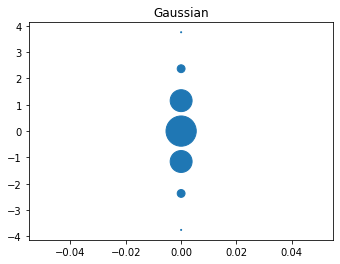

In [171]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[12, 4])

nodes, weights = gauss_quads[5]

pyplot.subplot(121)
pyplot.title("Gaussian")
pyplot.scatter(numpy.zeros_like(nodes),nodes, s=weights*2e3)



pyplot.show()

### 0-1 s

In [172]:
coordinates = numpy.linspace(0, 1, 1000)


def model_solver(parameters):
    """
    Simple ordinary differential equation solver.

    Args:
        parameters (numpy.ndarray):
            Hyper-parameters defining the model initial
            conditions alpha and growth rate beta.
            Assumed to have ``len(parameters) == 2``.

    Returns:
        (numpy.ndarray):
            Solution to the equation.
            Same shape as ``coordinates``.
    """
    theta  = parameters
    return numpy.e**-(coordinates*theta)

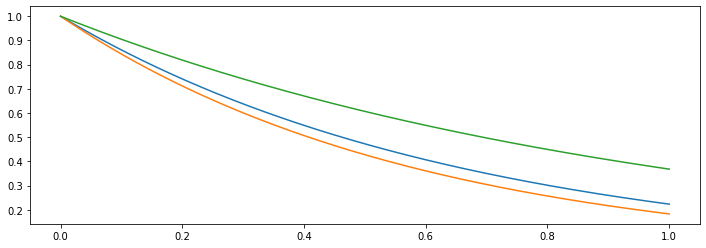

In [173]:
pyplot.plot(coordinates, model_solver([1.5]))
pyplot.plot(coordinates, model_solver([1.7]))
pyplot.plot(coordinates, model_solver([1.0]))

pyplot.show()

In [174]:
gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in gauss_quads
]

Text(0.5, 1.0, 'Gaussian')

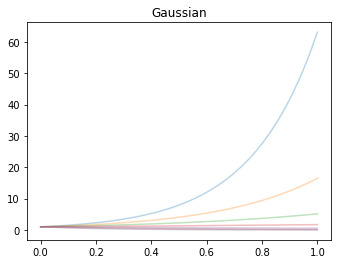

In [175]:
pyplot.subplot(121)
pyplot.plot(coordinates, gauss_evals[6].T, alpha=0.3)
pyplot.title("Gaussian")

In [176]:
expansions = [chaospy.generate_expansion(order, theta)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q0])

In [177]:
gauss_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, gauss_quads, gauss_evals)
]

Text(0.5, 1.0, 'Gaussian')

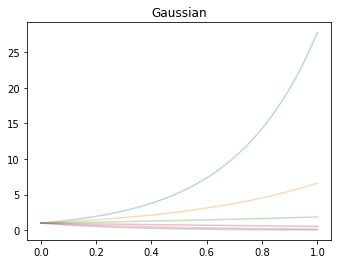

In [178]:
model_approx = gauss_model_approx[4]
nodes, _ = gauss_quads[4]
evals = model_approx(*nodes)

pyplot.subplot(121)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian")

In [179]:
expected = chaospy.E(gauss_model_approx[-2], theta)
std = chaospy.Std(gauss_model_approx[-2], theta)

expected[:4].round(4), std[:4].round(4)

(array([1., 1., 1., 1.]), array([0.   , 0.001, 0.002, 0.003]))

In [180]:
_t = coordinates[:]
true_mean = numpy.hstack(numpy.e**(0.5*_t**2))
# true_variance = numpy.hstack(11.45*(numpy.e**(-0.2*_t)-numpy.e**(-0.4*_t))/_t)-true_mean**2

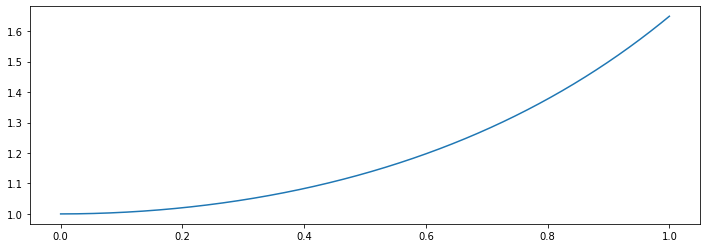

In [181]:
pyplot.plot(coordinates, true_mean)
pyplot.show()

In [182]:
def error_in_mean(predicted_mean, true_mean=true_mean):
    """
    How close the estimated mean is the to the true mean.

    Args:
        predicted_mean (numpy.ndarray):
            The estimated mean.
        true_mean (numpy.ndarray):
            The reference mean value. Must be same shape as
            ``prediction_mean``.

    Returns:
        (float):
            The mean absolute distance between predicted
            and true values.
    """
    return numpy.mean(numpy.abs(predicted_mean-true_mean)/true_mean)

In [183]:
gauss_sizes = [len(weights) for _, weights in gauss_quads]
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, theta))
    for model in gauss_model_approx
]

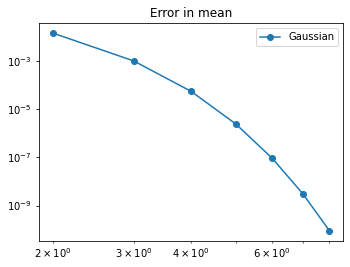

In [184]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(gauss_sizes, eps_gauss_mean, "o-", label="Gaussian")
pyplot.legend()


pyplot.show()

### 0-10 s

In [197]:
coordinates = numpy.linspace(0, 10, 1000)


def model_solver(parameters):
    """
    Simple ordinary differential equation solver.

    Args:
        parameters (numpy.ndarray):
            Hyper-parameters defining the model initial
            conditions alpha and growth rate beta.
            Assumed to have ``len(parameters) == 2``.

    Returns:
        (numpy.ndarray):
            Solution to the equation.
            Same shape as ``coordinates``.
    """
    theta  = parameters
    return numpy.e**-(coordinates*theta)

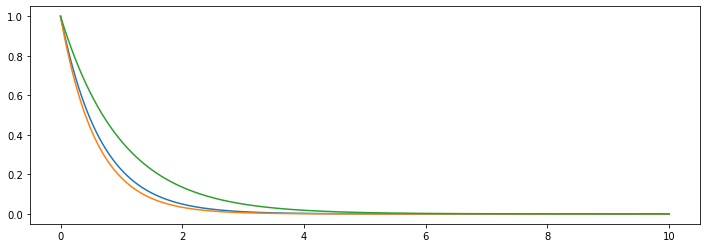

In [198]:
pyplot.plot(coordinates, model_solver([1.5]))
pyplot.plot(coordinates, model_solver([1.7]))
pyplot.plot(coordinates, model_solver([1.0]))

pyplot.show()

In [199]:
gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in gauss_quads
]

In [200]:
expansions = [chaospy.generate_expansion(order, theta)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q0])

In [201]:
gauss_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, gauss_quads, gauss_evals)
]

Text(0.5, 1.0, 'Gaussian')

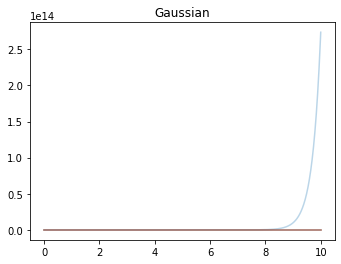

In [202]:
model_approx = gauss_model_approx[4]
nodes, _ = gauss_quads[4]
evals = model_approx(*nodes)

pyplot.subplot(121)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian")

In [203]:
expected = chaospy.E(gauss_model_approx[-2], theta)
std = chaospy.Std(gauss_model_approx[-2], theta)

expected[:4].round(4), std[:4].round(4)

(array([1.    , 1.0001, 1.0002, 1.0005]),
 array([0.    , 0.01  , 0.02  , 0.0301]))

In [204]:
_t = coordinates[:]
true_mean = numpy.hstack(numpy.e**(0.5*_t**2))
# true_variance = numpy.hstack(11.45*(numpy.e**(-0.2*_t)-numpy.e**(-0.4*_t))/_t)-true_mean**2

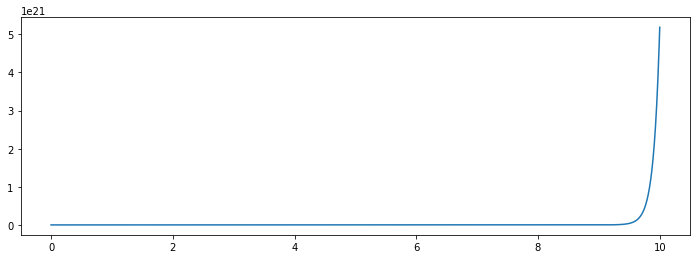

In [205]:
pyplot.plot(coordinates, true_mean)
pyplot.show()

In [206]:
def error_in_mean(predicted_mean, true_mean=true_mean):
    """
    How close the estimated mean is the to the true mean.

    Args:
        predicted_mean (numpy.ndarray):
            The estimated mean.
        true_mean (numpy.ndarray):
            The reference mean value. Must be same shape as
            ``prediction_mean``.

    Returns:
        (float):
            The mean absolute distance between predicted
            and true values.
    """
    return numpy.mean(numpy.abs(predicted_mean-true_mean)/true_mean)

In [207]:
gauss_sizes = [len(weights) for _, weights in gauss_quads]
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, theta))
    for model in gauss_model_approx
]

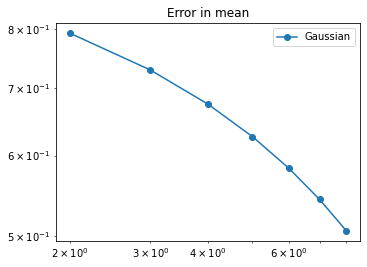

In [208]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(gauss_sizes, eps_gauss_mean, "o-", label="Gaussian")
pyplot.legend()


pyplot.show()